<a href="https://colab.research.google.com/github/Uma1709/intership/blob/main/week5_(deep_learning_49%2C50%2C51%2C52%2C53).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Toxic Comment Classification using RNN and LSTM

In [ ]:
!pip install seaborn


In [ ]:
!pip install plotly

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding,BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


#Movie Reviews Sentiment Analysis

In [ ]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/interships datasts(audio)/movie.csv")

In [ ]:
dataset.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


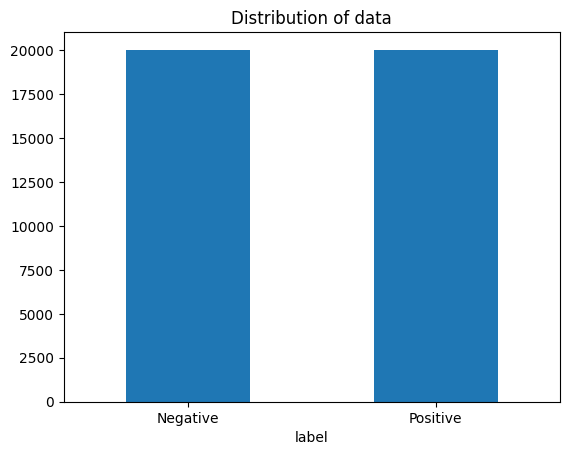

In [ ]:
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
contractions = pd.read_csv('/content/drive/MyDrive/interships datasts(audio)/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
linebreaks        = "<br /><br />"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_reviews(review):

    review = review.lower()

    review = re.sub(linebreaks," ",review)
    # Replace 3 or more consecutive letters by 2 letter.
    review = re.sub(sequencePattern, seqReplacePattern, review)

    # Replace all emojis.
    review = re.sub(r'<3', '<heart>', review)
    review = re.sub(smileemoji, '<smile>', review)
    review = re.sub(sademoji, '<sadface>', review)
    review = re.sub(neutralemoji, '<neutralface>', review)
    review = re.sub(lolemoji, '<lolface>', review)

    for contraction, replacement in contractions_dict.items():
        review = review.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    review = re.sub(alphaPattern, ' ', review)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    review = re.sub(r'/', ' / ', review)
    return review

In [ ]:
%%time
dataset['cleaned_review'] = dataset.text.apply(preprocess_reviews)

CPU times: user 16.4 s, sys: 45 ms, total: 16.4 s
Wall time: 16.6 s


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
dataset["cleaned_review"][0]

'i grew up  b  1965  watching and loving the thunderbirds  all my mates at school watched  we played  thunderbirds  before school  during lunch and after school  we all wanted to be virgil or scott  no one wanted to be alan  counting down from 5 became an art form  i took my children to see the movie hoping they would get a glimpse of what i loved as a child  how bitterly disappointing  the only high point was the snappy theme tune  not that it could compare with the original score of the thunderbirds  thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created  jonatha frakes should hand in his directors chair  his version was completely hopeless  a waste of film  utter rubbish  a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp  sapiens was a huge error of judgment '

In [ ]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# j = 0
for i in range(len(dataset)):
    lis = []
    for words in dataset["cleaned_review"][i].split():
        if words not in stop_words:
            words = lemmatizer.lemmatize(words)
            lis.append(words)
    dataset["cleaned_review"][i] = " ".join(lis)

#     j += 1
#     if j > 0:
#         break

In [ ]:
print(dataset["cleaned_review"][69])

kennan ivory wayans funny low dirty shame see one one worst done steven seagal help much start odd religious killing make much sense jim campbell keenan surprised see new partner waiting work side crack case jack cole seem everyone think jackis ex wife killed one ritual killing end making suspect well thing movie smoke past cia involvement trying normal cop steven dress like western movie prayer beeds top make thing little confusing


In [ ]:
data_pos = dataset[dataset["label"]==1]["cleaned_review"]
data_neg = dataset[dataset["label"]==0]["cleaned_review"]

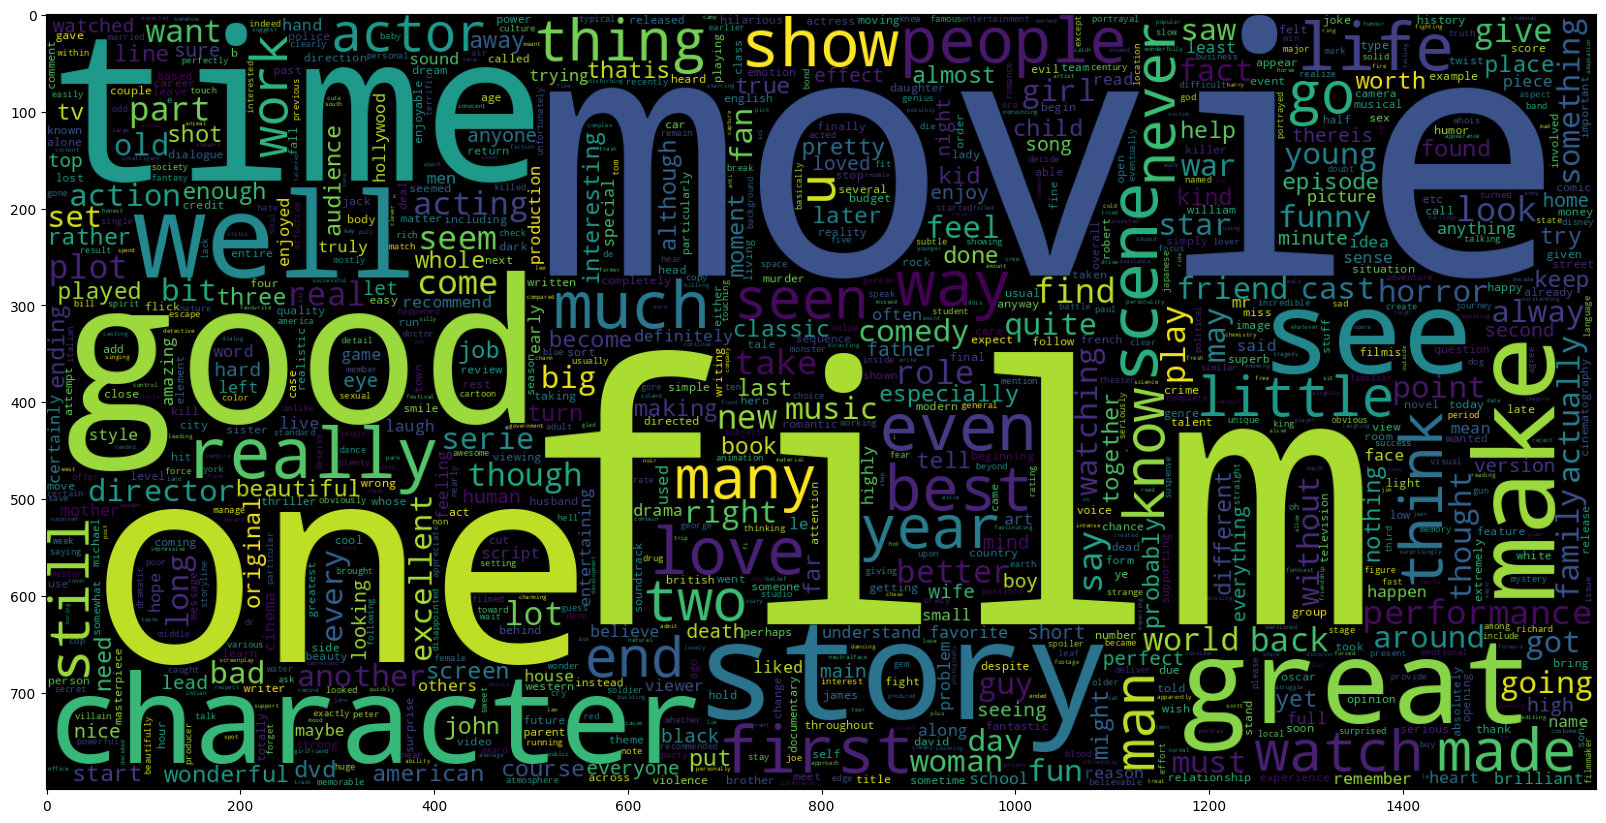

In [ ]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

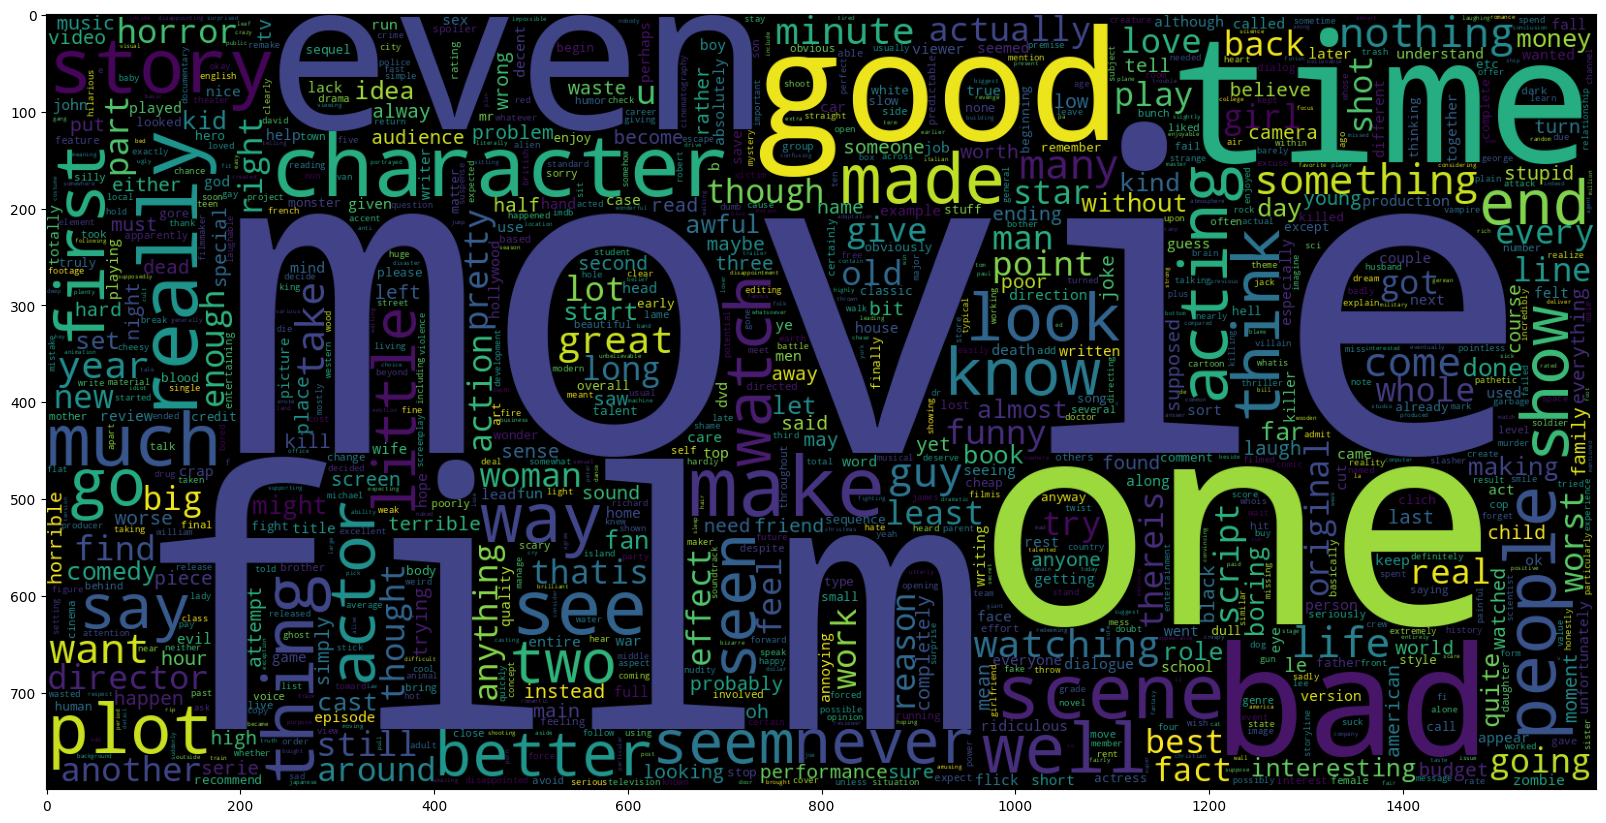

In [ ]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_data, y_data = np.array(dataset['cleaned_review']), np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 32781


In [ ]:
input_length = 750

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_length = 35000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 35000


In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (38000, 750)
X_test.shape : (2000, 750)


In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (35000, 100)


In [ ]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN,Dense,Activation,Bidirectional,GlobalMaxPool1D
from keras.utils.vis_utils import plot_model


ModuleNotFoundError: ignored

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Activation, Bidirectional, GlobalMaxPool1D
from keras.utils.vis_utils import plot_model


In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.utils import plot_model


In [ ]:
!pip install tensorflow


In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        SimpleRNN(100,input_shape = (vocab_length,input_length),return_sequences=False,activation="LeakyReLU"),
        Dense(32,activation="relu"),
        Dense(1,activation="sigmoid"),
    ],
     name="Sentiment_Model")
    return model
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 750, 100)          3500000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,523,365
Trainable params: 23,365
Non-trainable params: 3,500,000
_________________________________________________________________
